In [1]:
import pandas as pd
import numpy as np

from scipy import stats

import json
import clustering
from clustering.what_if_model import WhatIfModel
from clustering.pqp_input_parser import PQPInputParser
from clustering.util import create_model
import autoreload
import clustering.evaluation

%load_ext autoreload
%autoreload 2
pd.set_option('display.max_colwidth', -1)

In [2]:
BASE_PATH_TPCH = "~/Dokumente/repos/example_plugin/stats/final/tpch/sf1-2d/"
TPCH_ORDERKEY = f"{BASE_PATH_TPCH}/l_orderkey"
TPCH_SHIPDATE = f"{BASE_PATH_TPCH}/l_shipdate"

In [11]:
m = create_model("lineitem", PQPInputParser("tpch", TPCH_ORDERKEY), 2)

cost_model_output/models/


In [42]:
m.suggest_clustering(30)

array(['Semi'], dtype=object)

In [31]:
CLUSTERING_COLUMN = "l_shipdate"
SIDED = True
join_results = clustering.evaluation.evaluate_join_step(m, TPCH_SHIPDATE, [CLUSTERING_COLUMN], CLUSTERING_COLUMN, [100], "ALL", SIDED)


print(f"There are {len(join_results)} joins")
join_results[['QUERY_HASH1', 'DESCRIPTION1', 'RUNTIME_BASE', 'RUNTIME_ESTIMATE', 'RUNTIME_CLUSTERED', 'TOTAL_ERROR', 'RELATIVE_ERROR']]

## Estimating ColumnBetween scans
dropping columns OPERATOR_ID
## Estimating ColumnVsValue scans
dropping columns OPERATOR_ID

before
Empty DataFrame
Columns: [QUERY_HASH, PROBE_TABLE_ROW_COUNT, PROBE_COLUMN]
Index: []

after
Empty DataFrame
Columns: [QUERY_HASH, PROBE_TABLE_ROW_COUNT, PROBE_COLUMN]
Index: []


before
          QUERY_HASH  PROBE_TABLE_ROW_COUNT PROBE_COLUMN
30  140261541ac6b6ba  6001215.0              l_partkey  
31  140261541ac6b6ba  67068.0                l_suppkey  

after
          QUERY_HASH  PROBE_TABLE_ROW_COUNT PROBE_COLUMN
30  140261541ac6b6ba  960194.40              l_partkey  
31  140261541ac6b6ba  10730.88               l_suppkey  


before
Empty DataFrame
Columns: [QUERY_HASH, PROBE_TABLE_ROW_COUNT, PROBE_COLUMN]
Index: []

after
Empty DataFrame
Columns: [QUERY_HASH, PROBE_TABLE_ROW_COUNT, PROBE_COLUMN]
Index: []


before
           QUERY_HASH  PROBE_TABLE_ROW_COUNT PROBE_COLUMN
322  20e42e320de74706  6001215.0              l_orderkey 

after
           QU

Empty DataFrame
Columns: [QUERY_HASH, PROBE_TABLE_ROW_COUNT, PROBE_COLUMN]
Index: []

after
Empty DataFrame
Columns: [QUERY_HASH, PROBE_TABLE_ROW_COUNT, PROBE_COLUMN]
Index: []


before
Empty DataFrame
Columns: [QUERY_HASH, PROBE_TABLE_ROW_COUNT, PROBE_COLUMN]
Index: []

after
Empty DataFrame
Columns: [QUERY_HASH, PROBE_TABLE_ROW_COUNT, PROBE_COLUMN]
Index: []


before
           QUERY_HASH  PROBE_TABLE_ROW_COUNT PROBE_COLUMN
335  8e622f0e207e6f18  6001215.0              l_orderkey 

after
           QUERY_HASH  PROBE_TABLE_ROW_COUNT PROBE_COLUMN
335  8e622f0e207e6f18  360072.9               l_orderkey 


before
Empty DataFrame
Columns: [QUERY_HASH, PROBE_TABLE_ROW_COUNT, PROBE_COLUMN]
Index: []

after
Empty DataFrame
Columns: [QUERY_HASH, PROBE_TABLE_ROW_COUNT, PROBE_COLUMN]
Index: []


before
Empty DataFrame
Columns: [QUERY_HASH, PROBE_TABLE_ROW_COUNT, PROBE_COLUMN]
Index: []

after
Empty DataFrame
Columns: [QUERY_HASH, PROBE_TABLE_ROW_COUNT, PROBE_COLUMN]
Index: []


before
Empty Da

dropping columns OPERATOR_ID

There are 120 with estimated negative run time. This is bad.
           QUERY_HASH  \
228  10a29f9a2f853b35   
232  10a29f9a2f853b35   
234  10a29f9a2f853b35   
233  10a29f9a2f853b35   
34   140261541ac6b6ba   
35   140261541ac6b6ba   
158  1f28a146cc97b628   
162  1f28a146cc97b628   
164  1f28a146cc97b628   
163  1f28a146cc97b628   
67   21810eadacd14054   
726  2339c1c426815457   
727  2339c1c426815457   
746  26fa2b5482e6fcbc   
750  26fa2b5482e6fcbc   
752  26fa2b5482e6fcbc   
751  26fa2b5482e6fcbc   
637  306bc6df7241ccf9   
583  32494be5b6fe6fc3   
37   32c23f6f991a064d   
12   3534234c34669919   
13   3534234c34669919   
333  394be8faae0702a1   
103  3c13b8ba3d206f05   
127  409143bccde7fd31   
663  445e33c234f835dc   
664  445e33c234f835dc   
486  4d7c2c73839ab778   
483  4d7c2c73839ab778   
6    550d82dfc9e49105   
..                ...   
116  dbd83f57b52f1255   
120  dbd83f57b52f1255   
122  dbd83f57b52f1255   
121  dbd83f57b52f1255   
455  de53

383 joins with lineitem as probe or build side
There are 383 joins


,QUERY_HASH1,DESCRIPTION1,RUNTIME_BASE,RUNTIME_ESTIMATE,RUNTIME_CLUSTERED,TOTAL_ERROR,RELATIVE_ERROR
0,129f61e2f3ecf0ef,JoinHash (Inner Join where l_suppkey = s_suppkey) Radix bits: 0,132008,671589,92965,-578624,0.138425
1,140261541ac6b6ba,JoinHash (Semi Join where l_partkey = ps_partkey) Radix bits: 0,40469229,15464223,7217029,-8247194,0.466692
2,140261541ac6b6ba,JoinHash (Semi Join where l_suppkey = ps_suppkey) Radix bits: 0,9791895,8562728,2530095,-6032633,0.295478
3,140261541ac6b6ba,JoinHash (Semi Join where ps_suppkey = l_suppkey AND ps_availqty > 0.5 * SUM(l_quantity) AND ps_partkey = l_partkey) Radix bits: 0,4484800,2232014,3188252,956238,1.428419
4,19ae7b7a1d3226b,JoinHash (Semi Join where l_orderkey = o_orderkey) Radix bits: 0,60884667,69115293,110184220,41068927,1.594209
5,19ae7b7a1d3226b,JoinHash (Semi Join where o_orderkey = l_orderkey) Radix bits: 1,28402242,33472252,22490911,-10981341,0.671927
6,20e42e320de74706,JoinHash (Inner Join where l_orderkey = o_orderkey) Radix bits: 0,14620965,17188386,14641499,-2546887,0.851825
7,20e42e320de74706,JoinHash (Semi Join where l_orderkey = o_orderkey) Radix bits: 1,134690321,171175766,111897119,-59278647,0.653697
8,21810eadacd14054,JoinHash (Inner Join where l_suppkey = s_suppkey) Radix bits: 0,45683005,57893046,82139867,24246821,1.418821
9,21810eadacd14054,JoinHash (Inner Join where o_orderkey = l_orderkey) Radix bits: 2,104484101,134744198,134011700,-732498,0.994564


In [33]:
join_results['e'] = join_results['TOTAL_ERROR'] ** 2
join_results.sort_values(['e'], ascending=False)[["QUERY_HASH1", "DESCRIPTION1", "RUNTIME_BASE", "RUNTIME_ESTIMATE", "RUNTIME_CLUSTERED", "RELATIVE_ERROR", "TOTAL_ERROR"]]
#join_results.sort_values(['e'], ascending=False)[['DESCRIPTION1', 'TOTAL_ERROR']]
join_results.loc[362]

COLUMN_NAME          l_orderkey/o_orderkey                                           
DESCRIPTION1         JoinHash (Semi Join where l_orderkey = o_orderkey) Radix bits: 1
DESCRIPTION2         JoinHash (Semi Join where l_orderkey = o_orderkey) Radix bits: 1
QUERY_HASH1          f39f4116b27ebc04                                                
QUERY_HASH2          f39f4116b27ebc04                                                
RUNTIME_BASE         135911784                                                       
RUNTIME_ESTIMATE     172645908                                                       
RUNTIME_CLUSTERED    111496413                                                       
TOTAL_ERROR          -61149495                                                       
RELATIVE_ERROR       0.64581                                                         
e                    3739260738755025                                                
Name: 362, dtype: object

In [5]:
old_join_results = None

There are 383 operators

52% of the operator estimates are over- or underestimated between factor 1 and 1.5
34% of the operator estimates are over- or underestimated between factor 1.5 and 3
7% of the operator estimates are over- or underestimated between factor 3 and 100

Total estimate: 22599 ms
Total measured: 21197 ms
MSE: 667 ms^2
SMAPE: 49%


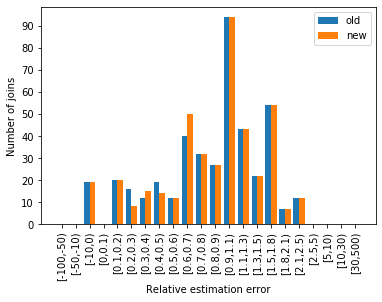

In [19]:
clustering.evaluation.print_aggregated_metrics(join_results, m.query_frequencies)
fig = clustering.evaluation.plot_join_errors(join_results, old_join_results, m.query_frequencies)
#old_join_results = join_results
fig

In [19]:
CLUSTERING_COLUMN = "l_shipdate"
scan_results = clustering.evaluation.evaluate_scans(m, TPCH_SHIPDATE, [CLUSTERING_COLUMN], CLUSTERING_COLUMN, [100])
print(f"There are {len(scan_results)} scans on {m.table_name}")

scan_results[['QUERY_HASH', 'DESCRIPTION1', 'RUNTIME_BASE', 'RUNTIME_ESTIMATE', 'RUNTIME_CLUSTERED', 'TOTAL_ERROR', 'RELATIVE_ERROR']].sort_values(['TOTAL_ERROR'], ascending=False)

## Estimating ColumnBetween scans
dropping columns PREDICATE_BetweenInclusive, PREDICATE_BetweenUpperExclusive
## Estimating ColumnVsValue scans
dropping columns PREDICATE_Equals, PREDICATE_LessThan, PREDICATE_LessThanEquals

## Estimating REFERENCE DATA joins
## Estimating REFERENCE REFERENCE joins

There are 91 scans on lineitem


,QUERY_HASH,DESCRIPTION1,RUNTIME_BASE,RUNTIME_ESTIMATE,RUNTIME_CLUSTERED,TOTAL_ERROR,RELATIVE_ERROR
16,4e4cb5b90ba5de03,TableScan Impl: ColumnVsValue l_shipdate <= '1998-08-04',35531182,9005800,19950263,10944463,2.215268
28,5aa537e0d658225a,TableScan Impl: ColumnVsValue l_shipdate <= '1998-08-09',36069135,9005800,12639155,3633355,1.403446
56,9a1adec8eeee6ec1,TableScan Impl: ColumnVsValue l_shipdate <= '1998-08-27',37732442,9146026,12734215,3588189,1.392322
81,f16984c46aa94970,TableScan Impl: ColumnVsValue l_shipdate <= '1998-09-01',35514908,9146026,12684554,3538528,1.386892
32,6081c4fbd55e16ea,TableScan Impl: ColumnVsValue l_shipdate <= '1998-09-08',33373366,9146026,11106459,1960433,1.214348
1,1a48bd3a39e20462,TableScan Impl: ColumnVsValue l_shipdate <= '1998-09-16',33777075,9146064,11072374,1926310,1.210616
69,d4f9e149097d68f9,TableScan Impl: ColumnVsValue l_shipdate <= '1998-08-18',33081621,9146026,11013704,1867678,1.204207
48,8368ab7c633a1ab2,TableScan Impl: ColumnVsValue l_quantity < 25,3676822,2441609,1993539,-448070,0.816486
15,497648c7e308ba08,TableScan Impl: ColumnVsValue l_quantity < 24,3755958,2441609,1987671,-453938,0.814082
19,522ef8893e703a3a,TableScan Impl: ColumnVsValue l_quantity < 24,3704342,2441609,1979989,-461620,0.810936


In [12]:
#old_scan_results = None
m.correlates_to_clustering_column('l_receip')

{'l_shipdate': ['l_receiptdate', 'l_commitdate'],
 'l_receiptdate': ['l_shipdate', 'l_commitdate']}

There are 91 operators

18% of the operator estimates are over- or underestimated between factor 1 and 1.5
37% of the operator estimates are over- or underestimated between factor 1.5 and 3
43% of the operator estimates are over- or underestimated between factor 3 and 100

Total estimate: 517 ms
Total measured: 275 ms
MSE: 14 ms^2
SMAPE: 96%


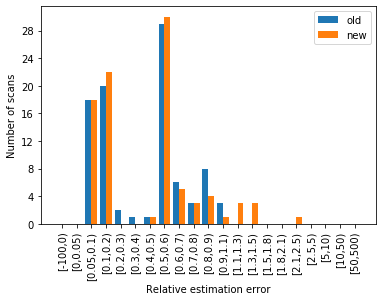

In [20]:
clustering.evaluation.print_aggregated_metrics(scan_results, m.query_frequencies)
fig = clustering.evaluation.plot_scan_errors(scan_results, old_scan_results, m.query_frequencies)
#old_scan_results = scan_results
fig

In [21]:
scan_results['e'] = scan_results['TOTAL_ERROR'] ** 2
scan_results['IMPLEMENTATION'] = scan_results.apply(lambda x: x['DESCRIPTION1'].split("Impl: ")[1].split()[0], axis=1)
scan_results['DESC'] = scan_results.apply(lambda x: " ".join(x['DESCRIPTION1'].split(" ")[3:]), axis=1)
scan_results.sort_values(['e'], ascending=False)[["QUERY_HASH", "DESC", "COLUMN_NAME", "RUNTIME_BASE", "RUNTIME_ESTIMATE", "RUNTIME_CLUSTERED", "TOTAL_ERROR", "RELATIVE_ERROR"]]
#scan_results['DESCRIPTION1'].apply(lambda x: "Like" in x).any()

,QUERY_HASH,DESC,COLUMN_NAME,RUNTIME_BASE,RUNTIME_ESTIMATE,RUNTIME_CLUSTERED,TOTAL_ERROR,RELATIVE_ERROR
16,4e4cb5b90ba5de03,l_shipdate <= '1998-08-04',l_shipdate,35531182,9005800,19950263,10944463,2.215268
39,6fb3f7e54d76ceed,l_shipdate <= '1998-09-27',l_shipdate,35856664,21715331,12801337,-8913994,0.589507
45,7a589f8ab18426d6,l_shipdate <= '1998-09-21',l_shipdate,38255098,21636078,12835910,-8800168,0.593264
4,3898d8ff5bfa1046,l_shipdate <= '1998-10-02',l_shipdate,42418676,21641693,13104188,-8537505,0.605507
29,5b8fbc10c745e39,l_receiptdate BETWEEN UPPER EXCLUSIVE '1993-01-01' AND '1994-01-01',l_receiptdate,17509851,7817493,1173270,-6644223,0.150083
78,ee94325d3e4bf0a8,l_receiptdate BETWEEN UPPER EXCLUSIVE '1997-01-01' AND '1998-01-01',l_receiptdate,16182082,7456062,1161395,-6294667,0.155765
88,fe56436b8c0d101,l_receiptdate BETWEEN UPPER EXCLUSIVE '1994-01-01' AND '1995-01-01',l_receiptdate,16157567,7494771,1208053,-6286718,0.161186
49,85c77cc53ff9fd3f,l_receiptdate BETWEEN UPPER EXCLUSIVE '1997-01-01' AND '1998-01-01',l_receiptdate,16004185,7456062,1175854,-6280208,0.157704
82,f2b5e28bd4c3992d,l_receiptdate BETWEEN UPPER EXCLUSIVE '1996-01-01' AND '1997-01-01',l_receiptdate,15699448,7326224,1134715,-6191509,0.154884
72,df6e2c89797dffb1,l_receiptdate BETWEEN UPPER EXCLUSIVE '1996-01-01' AND '1997-01-01',l_receiptdate,16172583,7326224,1138975,-6187249,0.155465


In [41]:
joindbg = pd.read_csv(TPCH_SHIPDATE + "/joins.csv", sep='|')
joindbg.dropna(inplace=True)
joindbg['BUILD_COLUMN'] = joindbg.apply(lambda x: x[f"{x['BUILD_SIDE']}_COLUMN_NAME"], axis=1)
joindbg['PROBE_COLUMN'] = joindbg.apply(lambda x: x[f"{x['PROBE_SIDE']}_COLUMN_NAME"], axis=1)
viewcols = ['QUERY_HASH', 'IS_FLIPPED', 'PROBE_SORTED', 'BUILD_SORTED', 'PROBE_COLUMN', 'BUILD_COLUMN', 'DESCRIPTION']
joindbg[joindbg['QUERY_HASH'] == '3534234c34669919'][viewcols]

,QUERY_HASH,IS_FLIPPED,PROBE_SORTED,BUILD_SORTED,PROBE_COLUMN,BUILD_COLUMN,DESCRIPTION
7,3534234c34669919,True,1,1,ps_partkey,p_partkey,JoinHash (Semi Join where ps_partkey = p_partkey) Radix bits: 0
8,3534234c34669919,True,1,1,l_partkey,ps_partkey,JoinHash (Semi Join where l_partkey = ps_partkey) Radix bits: 0
9,3534234c34669919,True,1,1,l_suppkey,ps_suppkey,JoinHash (Semi Join where l_suppkey = ps_suppkey) Radix bits: 0
10,3534234c34669919,True,1,0,ps_suppkey,l_suppkey,JoinHash (Semi Join where ps_suppkey = l_suppkey AND ps_availqty > 0.5 * SUM(l_quantity) AND ps_partkey = l_partkey) Radix bits: 0
11,3534234c34669919,True,1,1,s_suppkey,ps_suppkey,JoinHash (Semi Join where s_suppkey = ps_suppkey) Radix bits: 0
12,3534234c34669919,True,1,1,n_nationkey,s_nationkey,JoinHash (Semi Join where n_nationkey = s_nationkey) Radix bits: 0
13,3534234c34669919,True,1,1,s_nationkey,n_nationkey,JoinHash (Semi Join where s_nationkey = n_nationkey) Radix bits: 0
